# <font color='blue'>Data Science Academy - Machine Learning</font>

# <font color='blue'>Capítulo 12 - Processamento de Linguagem Natural</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


Obs: Este é um material de bônus incluído neste curso. PyTorch é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-frameworks">Deep Learning Frameworks</a> e aplicado em PLN no curso <a href="https://www.datascienceacademy.com.br/course?courseid=processamento-de-linguagem-natural-e-reconhecimento-de-voz">Processamento de Linguagem Natural</a>.

## Estudo de Caso - Previsão de Palavras com Base no Contexto e Visualização com PCA

![title](imagens/word2vec.png)

**A definição deste estudo de caso está no manual em pdf no Capítulo 12 do Curso de <a href="https://www.datascienceacademy.com.br/course?courseid=machine-learning-engineer">Machine Learning</a>**. 

Faça a leitura do manual antes de prosseguir com o Estudo de Caso.

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install torch==1.5.0

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Instala o PyTorch
!pip install -q torch 

In [4]:
# Pacote para gráficos com Scikit-learn
!pip install -q scikit-plot

In [5]:
# Imports
import torch
import scipy
import sklearn
import scikitplot
import numpy as np
import torch.nn.functional as F
from torch.optim import SGD
from torch.autograd import Variable, profiler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from scikitplot.decomposition import plot_pca_2d_projection
%matplotlib inline

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

sklearn    0.22.1
scipy      1.4.1
scikitplot 0.3.7
numpy      1.18.4
torch      1.5.0
Data Science Academy


### Preparação dos Dados

In [7]:
# Corpus
corpus = ['ele é um rei',
          'ela é uma rainha',
          'ele é um homem',
          'ela é uma mulher',
          'Madrid é a capital da Espanha',
          'Berlim é a capital da Alemanha',
          'Lisboa é a capital de Portugal']

In [8]:
# Construindo o vocabulário com tokenização
palavras = []
for sentence in corpus:
    for palavra in sentence.split():
         if palavra not in palavras:
            palavras.append(palavra)

In [9]:
# Visualiza os dados
palavras

['ele',
 'é',
 'um',
 'rei',
 'ela',
 'uma',
 'rainha',
 'homem',
 'mulher',
 'Madrid',
 'a',
 'capital',
 'da',
 'Espanha',
 'Berlim',
 'Alemanha',
 'Lisboa',
 'de',
 'Portugal']

In [10]:
# Criamos o mapeamento palavra - índice   
word2idx = {w:idx for (idx, w) in enumerate(palavras)}
word2idx

{'ele': 0,
 'é': 1,
 'um': 2,
 'rei': 3,
 'ela': 4,
 'uma': 5,
 'rainha': 6,
 'homem': 7,
 'mulher': 8,
 'Madrid': 9,
 'a': 10,
 'capital': 11,
 'da': 12,
 'Espanha': 13,
 'Berlim': 14,
 'Alemanha': 15,
 'Lisboa': 16,
 'de': 17,
 'Portugal': 18}

In [11]:
# Criamos o mapeamento inverso índice - palavra
idx2word = {idx:w for (idx, w) in enumerate(palavras)}
idx2word

{0: 'ele',
 1: 'é',
 2: 'um',
 3: 'rei',
 4: 'ela',
 5: 'uma',
 6: 'rainha',
 7: 'homem',
 8: 'mulher',
 9: 'Madrid',
 10: 'a',
 11: 'capital',
 12: 'da',
 13: 'Espanha',
 14: 'Berlim',
 15: 'Alemanha',
 16: 'Lisboa',
 17: 'de',
 18: 'Portugal'}

In [12]:
# Tamanho do vocabulário
tamanho_vocab = len(word2idx)
tamanho_vocab

19

### Construção do Modelo

In [13]:
# Função para gerar os embeddings
def get_word_embedding(word):
    word_vec_one_hot = np.zeros(tamanho_vocab)
    word_vec_one_hot[word2idx[word]] = 1
    return word_vec_one_hot

In [14]:
# Função para gerar os vetores, da palavra central e do contexto
def gera_vetores():
    for sentence in corpus:
        words = sentence.split()
        indices = [word2idx[w] for w in words]
        
        # Loop pelo range de índices
        # Aqui geramos o vetor da palavra central em i
        # E geramos o vetor de contexto
        for i in range(len(indices)):
            for w in range(-window_size, window_size + 1):
                context_idx = i + w
                if context_idx < 0 or context_idx >= len(indices) or i == context_idx:
                    continue
                    
                # Gera os vetores    
                center_vec_one_hot = np.zeros(tamanho_vocab)
                center_vec_one_hot[indices[i]] = 1
                context_idx = indices[context_idx]
                                
                yield center_vec_one_hot, context_idx

In [15]:
# Hiperparâmetros
embedding_dims = 10
window_size = 2

Definição dos pesos da rede neural.

- W1 é uma matriz de pesos de dimensões embedding_dims x tamanho_vocab
- W2 é uma matriz de pesos de dimensões tamanho_vocab x embedding_dims

Os pesos (ou coeficientes ou parâmetros) é aquilo que a rede aprende durante o treinamento. Como no início não sabemos qual o valor ideal de pesos (isso é o que queremos descobrir) iniciamos com valores randômicos usando torch.randn().

Ao final do aprendizado, o modelo em si nada mais é do que os valores ideais de W1 e W2.

In [16]:
# Definição dos pesos da rede neural
W1 = Variable(torch.randn(embedding_dims, tamanho_vocab).float(), requires_grad = True)
W2 = Variable(torch.randn(tamanho_vocab, embedding_dims).float(), requires_grad = True)

In [17]:
# Treinamento
print("\nIniciando o Treinamento...\n")
for epoch in range(1001):
    
    # Inicializa o erro médio da rede
    avg_loss = 0
    
    # Inicializa o controle do número de amostras
    samples = 0
    
    # Loop pelos dados (vetores de entrada)
    for data, target in gera_vetores():
        
        # Coleta x (vetor da palavra central)
        x = Variable(torch.from_numpy(data)).float()
        
        # Coleta y (vetor do contexto)
        y_true = Variable(torch.from_numpy(np.array([target])).long())
        
        # Atualiza o número de amostras
        samples += len(y_true)
        
        # Resultado da multiplicação entre os pesos e as primeiras camadas da rede
        a1 = torch.matmul(W1, x)
        a2 = torch.matmul(W2, a1)

        # A função softmax entrega a probabilidade da previsão da rede
        log_softmax = F.log_softmax(a2, dim = 0)

        # Previsão da rede
        network_pred_dist = F.softmax(log_softmax, dim = 0)
        
        # Calcula o erro, comparando a previsão da rede com o valor real 
        # (como fazemos em qualquer modelo de aprendizagem supervisionada)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        
        # Erro médio
        avg_loss += loss.item()
        
        # Inicia o backpropagation
        loss.backward()

        # Atualiza o valor dos pesos para a próxima passada
        W1.data -= 0.002 * W1.grad.data
        W2.data -= 0.002 * W2.grad.data

        # Zera o valor do gradiente depois de atualizar os pesos
        W1.grad.data.zero_()
        W2.grad.data.zero_()
        
    # Imprime o erro da rede
    if epoch % 10 == 0:
        print('Erro de Treinamento:', avg_loss / samples)

print("\nTreinamento Concluído.")


Iniciando o Treinamento...

Erro de Treinamento: 5.22385479700058
Erro de Treinamento: 3.860058443977478
Erro de Treinamento: 3.2681373268999954
Erro de Treinamento: 2.9334868706287223
Erro de Treinamento: 2.7041754703572454
Erro de Treinamento: 2.5358102543556944
Erro de Treinamento: 2.4052776795752506
Erro de Treinamento: 2.299734469423903
Erro de Treinamento: 2.2126814317195973
Erro de Treinamento: 2.140747587731544
Erro de Treinamento: 2.081373210917128
Erro de Treinamento: 2.0319503219203745
Erro de Treinamento: 1.9900661621322022
Erro de Treinamento: 1.9538266554157784
Erro de Treinamento: 1.9218834797118574
Erro de Treinamento: 1.8933224414891385
Erro de Treinamento: 1.867533139091857
Erro de Treinamento: 1.8441056298448684
Erro de Treinamento: 1.8227571299735537
Erro de Treinamento: 1.8032803253290501
Erro de Treinamento: 1.7855086015894057
Erro de Treinamento: 1.7692917956316725
Erro de Treinamento: 1.7544840853264991
Erro de Treinamento: 1.7409412743563348
Erro de Treinament

### Teste do Modelo e Redução de Dimensionalidade com PCA

Para testar o modelo, tudo que precisamos é dos pesos, em nosso exemplo W1 e W2. Mas visualizar os dados é desafiador, pois a dimensionalidade é alta e quanto maior o número de palavras do vocabulário, mais complicado.

Uma alternativa, é reduzir a diemensionalidade dos dados. Convertemos todos os atributos em 2 componentes principais usando PCA (Principal Component Analysis) e com 2 componentes podemos visualizar os dados.

Cada componentes principal nada mais é do que a junção matemática da informação em outras variáveis. O PCA é um algoritmo de Machine Learning por si mesmo, da categoria de aprendizagem não supervisionada.

Vamos aplicar o PCA para visualizar os dados.

In [18]:
# Cria o objeto para redução de dimensionalidade
pca = PCA(n_components = 2)

In [19]:
# Treina o modelo PCA
pca.fit(W1.data.numpy().T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [20]:
# Calcula a projeção PCA para o Plot
proj = pca.transform(W1.data.numpy().T)

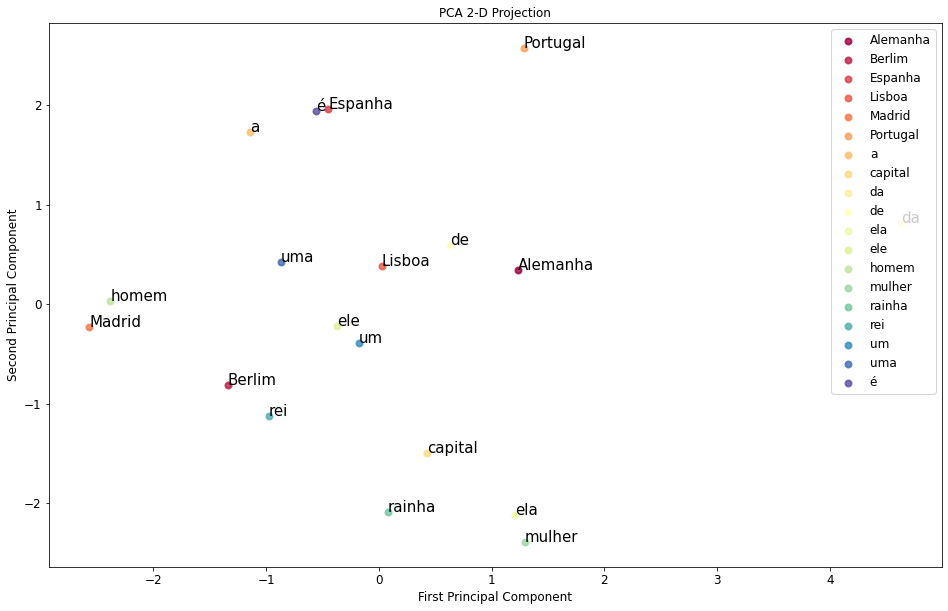

In [21]:
# Plot
ax = plot_pca_2d_projection(pca, 
                            W1.data.numpy().T, 
                            np.array(palavras), 
                            feature_labels = palavras, 
                            figsize = (16,10), 
                            text_fontsize = 12)

# Legenda
for i, txt in enumerate(palavras):
    ax.annotate(txt, (proj[i,0], proj[i,1]), size = 15)

Observe a legenda no gráfico acima! Palavras similares com base no contexto, estão com a "bolinha" com cores parecidas. No topo da lista temos países e cidades, depois pronomes e a palavra "capital", temos então homem, mulher, rainha e rei e por fim artigos e um verbo.

Tudo isso foi aprendido pela rede com base no contexto, que nada mais é do que a distância de cosseno entre as embeddings, os vetores que representam as palavras.

A visualização acima mostra que palavras que estão na mesma direção possui alguma similaridade, por exemplo "Alemanha" e "Berlim". Passe uma linha reta imaginária que "corta" as palavras "Alemanha" e "Berlim". Consegue? Se a resposta for sim, as palavras são similares. Abaixo terá outro exemplo.

Vamos extrair as distâncias com base na pergunta:

**Espanha está para Madrid, assim como Alemanha está para ?**

Vamos perguntar ao modelo.

In [22]:
# Função para obter um vetor de palavras no peso W1 (esse é o contexto)
def get_word_vector_v(word):
    return W1[:, word2idx[word]].data.numpy()

In [23]:
# Função para obter um vetor de palavras no peso W2 (essa é a palavra central)
def get_word_vector_u(word):
    return W2[word2idx[word],:].data.numpy()

In [25]:
# Vamos obter os vetores das palavras
espanha = 1 * get_word_vector_v('Espanha') + 1 * get_word_vector_u('Espanha')
alemanha = 1 * get_word_vector_v('Alemanha') + 1 * get_word_vector_u('Alemanha') 
madrid = 1 * get_word_vector_v('Madrid') + 1 * get_word_vector_u('Madrid') 

In [26]:
# Resultado
resultado = madrid - espanha + alemanha

O que fizemos acima foi um cálculo vetorial e toda a Matemática por trás desse processo é estudada em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=matematica-para-machine-learning">Matemática Para Machine Learning</a>.

In [27]:
# Este é o resultado, ou seja, uma embedding que representa a palavra mais similar à palavra "Alemanha",
# com base na similaridade (contexto) entre "Polônia" e "Varsóvia".
resultado

array([-0.40513015,  0.7897184 , -2.2216756 ,  3.2241647 ,  2.8210957 ,
       -0.6236031 , -1.7174951 ,  2.8691614 , -2.4253767 , -2.8065045 ],
      dtype=float32)

In [28]:
# Vamos extrair as distâncias de todas as outras palavras para a nossa palavra "secreta" que está 
# no vetor embedding chamado "resultado"
# Usamos a função cosine() do SciPy para calcular as distâncias
distancias = [(v, cosine(resultado, 1 * get_word_vector_u(v) + 1 * get_word_vector_v(v))) for v in palavras]

In [29]:
# Visualiza as distâncias
distancias

[('ele', 1.3965722024440765),
 ('é', 0.9767543282359838),
 ('um', 1.1265821009874344),
 ('rei', 1.2847048044204712),
 ('ela', 1.611805021762848),
 ('uma', 1.1790071874856949),
 ('rainha', 1.5804210901260376),
 ('homem', 0.9397386945784092),
 ('mulher', 1.0231596734374762),
 ('Madrid', 0.2463206648826599),
 ('a', 0.6906205117702484),
 ('capital', 1.5314018726348877),
 ('da', 1.2638142704963684),
 ('Espanha', 1.4653907418251038),
 ('Berlim', 0.5861693322658539),
 ('Alemanha', 0.7063304781913757),
 ('Lisboa', 0.819067195057869),
 ('de', 1.1880789548158646),
 ('Portugal', 1.3572377264499664)]

Acima temos uma lista de tuplas com as distâncias de cada palavra para nosso "resultado". Vamos ordenar isso.

In [30]:
# Ordenando a lista de tuplas pelo segundo elemento da tupla
distancias.sort(key = lambda tup: tup[1])  

In [31]:
# Agora sim
distancias

[('Madrid', 0.2463206648826599),
 ('Berlim', 0.5861693322658539),
 ('a', 0.6906205117702484),
 ('Alemanha', 0.7063304781913757),
 ('Lisboa', 0.819067195057869),
 ('homem', 0.9397386945784092),
 ('é', 0.9767543282359838),
 ('mulher', 1.0231596734374762),
 ('um', 1.1265821009874344),
 ('uma', 1.1790071874856949),
 ('de', 1.1880789548158646),
 ('da', 1.2638142704963684),
 ('rei', 1.2847048044204712),
 ('Portugal', 1.3572377264499664),
 ('ele', 1.3965722024440765),
 ('Espanha', 1.4653907418251038),
 ('capital', 1.5314018726348877),
 ('rainha', 1.5804210901260376),
 ('ela', 1.611805021762848)]

O vetor "resultado" foi uma previsão do nosso modelo e as palavras "Madrid" e "Berlim" são as mais similares. Observe que "Berlim" é a palavra mais similar com base no conexto, uma vez que Madrid já foi usada em nossa fórmula.

Imagine que um vetor (uma flecha) sai da origem do sistema de coordenadas (Honestidade = 0 e Experiência = 0, chamaremos de ponto O) e termina no ponto X. Este vetor é usado para localizar o ponto no nosso espaço de características. Não é diferente de simplesmente dizer que X possui H = 0.4 e E = 0.2, é apenas outra maneira de ver isso.

![title](imagens/cos.png)

Se soubermos qual é o ângulo entre os vetores X e A, podemos usar uma calculadora simples e calcular a similaridade. Podemos ver pela imagem acima que os vetores de X e A estão sobre a mesma linha reta (observe as cores dos círculos na legenda), logo o ângulo entre eles é zero graus e sua similaridade é cos(0) = 1. Já para a similaridade entre X e B não sabemos o ângulo e precisamos usar uma equação. O numerador (a parte de cima da divisão) significa multiplicar os valores de Honestidade de X e B e somar com a multiplicação dos valores de Experiência de X e B.

Isso é o que faz o Word2vec. Brihante, não?

**Em que contexto aparece a palavra Lisboa?**

Aqui é como se estivéssemos usando o modelo para previsão.

In [33]:
# Extrai o contexto
context_to_predict = get_word_vector_v('Lisboa')

# Variável com o contexto a prever
hidden = Variable(torch.from_numpy(context_to_predict)).float()

# Executa o modelo e extrai as probabilidades 
# (executar o modelo nada mais é do que multiplicar os novos dados de entrada pelos pesos aprendidos no treinamento)
a = torch.matmul(W2, hidden)
probs = F.softmax(a, dim = 0).data.numpy()

# Imprime o resultado
for context, prob in zip(palavras, probs):
    print(f'{context}: {prob}')

ele: 0.0001222703722305596
é: 0.4867992699146271
um: 5.335334572009742e-05
rei: 0.00023161662102211267
ela: 2.728262188611552e-05
uma: 0.007864093407988548
rainha: 0.0006475533591583371
homem: 0.0009029505308717489
mulher: 0.00039312048465944827
Madrid: 0.0013700221898034215
a: 0.487895667552948
capital: 0.0003848224296234548
da: 0.0018237640615552664
Espanha: 0.00018272449960932136
Berlim: 0.00152174464892596
Alemanha: 0.0006373585783876479
Lisboa: 0.003759471233934164
de: 0.0024602694902569056
Portugal: 0.002922620391473174


O contexto da palavra "Lisboa" é representado pelas palavras "é", "a", "Portugal".

Nosso modelo não conseguiu aprender o contexto "capital". Quem sabe você consegue otimizar o treinamento do modelo e aumentar sua precisão.

# Fim